# <h1 align="center">**Movie Review Sentiment Checker**</h1>

<br>

### **Author**: APDOOLMAJEED HAMZA (apdoolhamza) (<a href="https://www.linkedin.com/in/apdoolhamza" target="_blank">LinkedIn</a>)

### **Project**: <a href="https://github.com/apdoolhamza/Movie-Review-Sentiment-Classifier/blob/main/docs/Sentiment_analysis_report.pdf" target="_blank">Full Documentation</a>  |    <a href="https://huggingface.co/spaces/apdoolhamza/MovieSentimentAI" target="_blank">Live Demo</a> |   <a href="https://github.com/apdoolhamza/Movie-Review-Sentiment-Classifier" target="_blank">GitHub</a>

#Install & Import Libraries

In [ ]:
!pip install scikit-learn matplotlib seaborn wordcloud joblib -q

print("Setup complete!")

Setup complete!


In [ ]:
hiimport pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    HalvingGridSearchCV
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    precision_recall_curve
)

import joblib

# import warnings
# warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid")

# Load & Clean the Data (IMDB-Dataset)

In [ ]:
def clean_text(text):
    """
    Minimal cleaning for IMDB dataset:
    - Remove HTML tags
    - Remove line breaks
    - Remove extra spaces
    """
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # Remove line breaks and tabs
    text = text.replace("\n", " ").replace("\r", " ").replace("\t", " ")

    # Normalize multiple spaces to single
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Load data
url_sent = "https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/IMDB-Dataset.csv"
df_sent = pd.read_csv(url_sent)
print(df_sent.head())
print("\nClass distribution:\n", df_sent['sentiment'].value_counts(normalize=True))

df_sent['clean_text'] = df_sent['review'].apply(clean_text)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Class distribution:
 sentiment
positive    0.5
negative    0.5
Name: proportion, dtype: float64


In [ ]:
df_sent['clean_text'].head()

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. The filming tec...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: clean_text, dtype: str

#EDA & Visualization

## Class balance

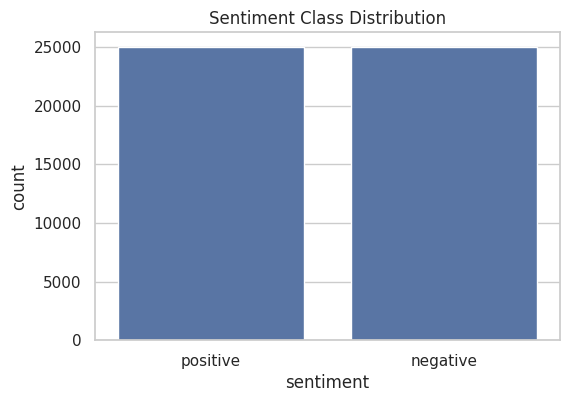

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_sent, x='sentiment')
plt.title("Sentiment Class Distribution")
plt.show()

## Text length

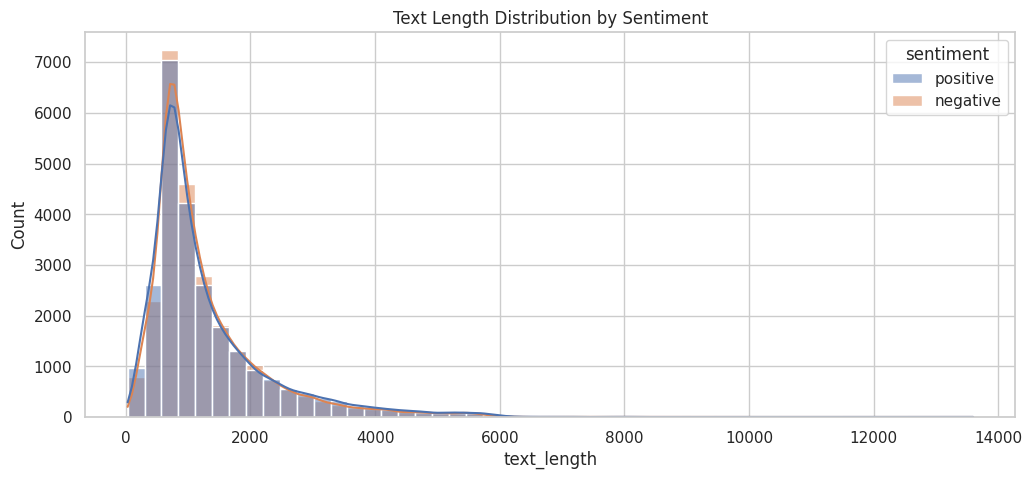

In [ ]:
df_sent['text_length'] = df_sent['clean_text'].str.len()
plt.figure(figsize=(12,5))
sns.histplot(df_sent, x='text_length', hue='sentiment', bins=50, kde=True)
plt.title("Text Length Distribution by Sentiment")
plt.show()

## Wordclouds

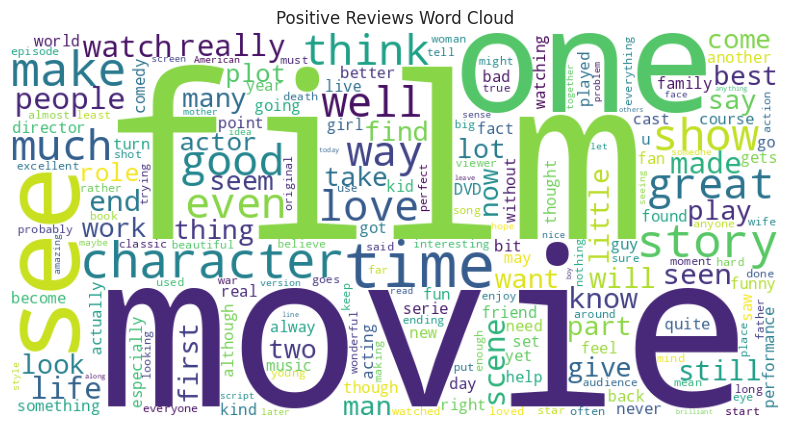

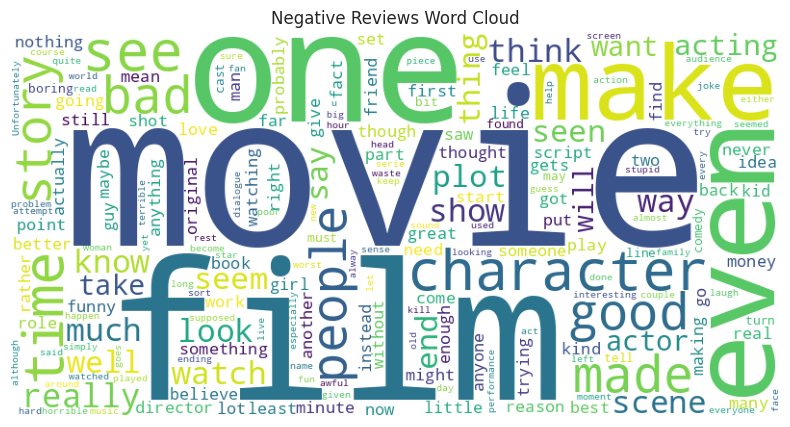

In [ ]:
def generate_wordcloud(texts, title):
    wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(texts))
    plt.figure(figsize=(10,5))
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title)
    plt.show()

pos_texts = df_sent[df_sent['sentiment']=='positive']['clean_text']
neg_texts = df_sent[df_sent['sentiment']=='negative']['clean_text']
generate_wordcloud(pos_texts, "Positive Reviews Word Cloud")
generate_wordcloud(neg_texts, "Negative Reviews Word Cloud")

## Model Pipeline + Training (TF-IDF + LinearSVC)

In [ ]:
X = df_sent['clean_text']
y = df_sent['sentiment'].map({'positive': 1, 'negative': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipe_sent = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=5, max_df=0.9, sublinear_tf=True)),
    ('clf', LinearSVC(C=0.8, dual=False, class_weight='balanced', max_iter=2000, random_state=42))
])

# Cross-validation baseline
cv_scores = cross_val_score(pipe_sent, X_train, y_train, cv=5, scoring='f1')
print(f"CV F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Hyperparameter tuning (efficient HalvingGridSearchCV)
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_features': [20000, 30000],
    'clf__C': [0.5, 0.8, 1.2]
}

search = HalvingGridSearchCV(pipe_sent, param_grid, cv=3, factor=2, scoring='f1', n_jobs=-1, random_state=42)
search.fit(X_train, y_train)
print("Best params:", search.best_params_)

best_pipe = search.best_estimator_

CV F1: 0.9069 ± 0.0021
Best params: {'clf__C': 0.5, 'tfidf__max_features': 30000, 'tfidf__ngram_range': (1, 2)}


#Calibration, Evaluation & Visualizations
(I used isotonic for better probability calibration)

In [ ]:
calibrated = CalibratedClassifierCV(best_pipe, method='isotonic')
calibrated.fit(X_train, y_train)

,"estimator estimator: estimator instance, default=NoneThe classifier whose output need to be calibrated to provide moreaccurate `predict_proba` outputs. The default classifier isa :class:`~sklearn.svm.LinearSVC`... versionadded:: 1.2",Pipeline(step...m_state=42))])
,"method method: {'sigmoid', 'isotonic', 'temperature'}, default='sigmoid'The method to use for calibration. Can be:- 'sigmoid', which corresponds to Platt's method (i.e. a binary logistic regression model).- 'isotonic', which is a non-parametric approach.- 'temperature', temperature scaling.Sigmoid and isotonic calibration methods natively support only binaryclassifiers and extend to multi-class classification using a One-vs-Rest (OvR)strategy with post-hoc renormalization, i.e., adjusting the probabilities aftercalibration to ensure they sum up to 1.In contrast, temperature scaling naturally supports multi-class calibration byapplying `softmax(classifier_logits/T)` with a value of `T` (temperature)that optimizes the log loss.For very uncalibrated classifiers on very imbalanced datasets, sigmoidcalibration might be preferred because it fits an additional interceptparameter. This helps shift decision boundaries appropriately when theclassifier being calibrated is biased towards the majority class.Isotonic calibration is not recommended when the number of calibration samplesis too low ``(≪1000)`` since it then tends to overfit... versionchanged:: 1.8 Added option 'temperature'.",'isotonic'
,"cv cv: int, cross-validation generator, or iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross-validation,- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. If ``y`` isneither binary nor multiclass, :class:`~sklearn.model_selection.KFold`is used.Refer to the :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors.Base estimator clones are fitted in parallel across cross-validationiterations.See :term:`Glossary ` for more details... versionadded:: 0.24",None
,"ensemble ensemble: bool, or ""auto"", default=""auto""Determines how the calibrator is fitted.""auto"" will use `False` if the `estimator` is a:class:`~sklearn.frozen.FrozenEstimator`, and `True` otherwise.If `True`, the `estimator` is fitted using training data, andcalibrated using testing data, for each `cv` fold. The final estimatoris an ensemble of `n_cv` fitted classifier and calibrator pairs, where`n_cv` is the number of cross-validation folds. The output is theaverage predicted probabilities of all pairs.If `False`, `cv` is used to compute unbiased predictions, via:func:`~sklearn.model_selection.cross_val_predict`, which are thenused for calibration. At prediction time, the classifier used is the`estimator` trained on all the data.Note that this method is also internally implemented in:mod:`sklearn.svm` estimators with the `probabilities=True` parameter... versionadded:: 0.24.. versionchanged:: 1.6 `""auto""` option is added and is the default.",'auto'
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files 

# Predict & evaluation

In [ ]:
y_pred = calibrated.predict(X_test)
y_proba = calibrated.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=4))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

              precision    recall  f1-score   support

           0     0.9161    0.9132    0.9147      5000
           1     0.9135    0.9164    0.9149      5000

    accuracy                         0.9148     10000
   macro avg     0.9148    0.9148    0.9148     10000
weighted avg     0.9148    0.9148    0.9148     10000

ROC-AUC: 0.9728


# Confusion Matrix

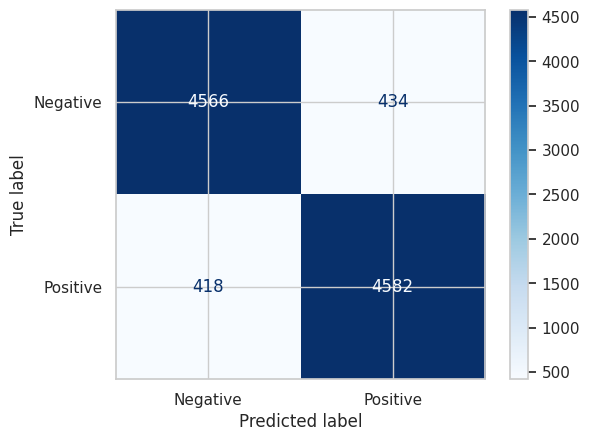

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.show()

# ROC Curve

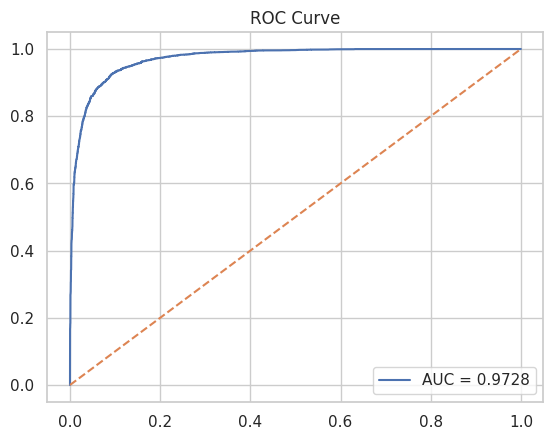

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.4f}')
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve")
plt.legend()
plt.show()

# Save the model

In [ ]:
joblib.dump(calibrated, "sentiment_model_calibrated.joblib")

['sentiment_model_calibrated.joblib']

# Import and Run

In [ ]:
import gradio as gr
import joblib

model = joblib.load("sentiment_model_calibrated.joblib")

def predict(text):
    clean_text = clean_text(text)
    prob = model.predict_proba([clean_text])[0][1]
    label = "Positive" if prob > 0.5 else "Negative"
    return f"{label} ({prob:.1%})"

demo = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(label="Enter review or sentence"),
    outputs=gr.Textbox(label="Prediction"),
    title="Movie Review Sentiment Checker",
    description="Type any sentence and see if it's predicted positive or negative."
)

demo.launch()